In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# ----------------------------
# 0. Parameters & Output Dir
# ----------------------------
dataset_path    = "/Users/rooj/Documents/RP3-Main/RP3-Imp/clean-datasets/2018.csv"
sample_fraction = 0.15       # fraction of windows (post_sequence) or rows (contiguous)
sampling_method = "post_sequence"  # or "contiguous"
window_size     = 10         # change your sequence length here
run_name        = f"lstm_{sampling_method}_{int(sample_fraction*100)}pct_w{window_size}_trail001"
output_folder   = os.path.join("outputs", "2018", "LSTM", run_name)
os.makedirs(output_folder, exist_ok=True)
print("Outputs →", output_folder)

# ----------------------------
# 1. Load & Clean Data
# ----------------------------
df_full = pd.read_csv(dataset_path, low_memory=False)
df_full = df_full[df_full['label'] != 'label'].reset_index(drop=True)
print("Raw rows:", df_full.shape[0])

Outputs → outputs/2018/LSTM/lstm_post_sequence_15pct_w10_trail001
Raw rows: 4339650


In [2]:
# ----------------------------
# 2. Encode Labels with LabelEncoder
# ----------------------------
encoder = LabelEncoder()
df_full['label_enc'] = encoder.fit_transform(df_full['label'])
joblib.dump(encoder, os.path.join(output_folder, "label_encoder.pkl"))
print("Label mapping:", dict(enumerate(encoder.classes_)))

# ----------------------------
# 3. Select Features
# ----------------------------
features = [c for c in df_full.columns if c.lower() not in ['timestamp','label','label_enc']]
print("Features:", features)

# ----------------------------
# 4. Sampling & Sequencing
# ----------------------------
def contiguous_sample(df, frac):
    n     = int(len(df)*frac)
    start = np.random.randint(0, len(df)-n)
    return df.iloc[start:start+n].reset_index(drop=True)

def post_sequence_sample(Xs, ys, frac, seed=42):
    np.random.seed(seed)
    n   = int(len(Xs)*frac)
    idx = np.random.choice(len(Xs), n, replace=False)
    return Xs[idx], ys[idx]

# choose raw df for windowing
if sampling_method=="contiguous":
    df = contiguous_sample(df_full, sample_fraction)
else:
    df = df_full.copy()

# drop NA, scale
df = df.dropna(subset=features + ['label_enc']).reset_index(drop=True)
X_raw = df[features].values
y_raw = df['label_enc'].values
scaler = StandardScaler().fit(X_raw)
X_scaled = scaler.transform(X_raw)
joblib.dump(scaler, os.path.join(output_folder,"scaler.pkl"))

# create sequences
def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X)-timesteps+1):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps-1])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_raw, window_size)
print("All windows:", X_seq.shape)

# optional post-sequence subsample
if sampling_method=="post_sequence" and sample_fraction<1.0:
    X_seq, y_seq = post_sequence_sample(X_seq, y_seq, sample_fraction)
    print("After post_sequence sampling:", X_seq.shape)

Label mapping: {0: 'Benign', 1: 'DDOS attack-HOIC', 2: 'DDOS attack-LOIC-UDP', 3: 'DDoS attacks-LOIC-HTTP', 4: 'DoS attacks-GoldenEye', 5: 'DoS attacks-Hulk', 6: 'DoS attacks-SlowHTTPTest', 7: 'DoS attacks-Slowloris'}
Features: ['Dst Port', 'protocol', 'Flow Duration', 'Flow Duration_rolling_mean', 'Flow Duration_rolling_std', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'SYN Flag Cnt', 'pkts_ratio', 'byte_per_duration', 'entropy_pkt_len', 'Subflow Fwd Byts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min']
All windows: (4339641, 10, 24)
After post_sequence sampling: (650946, 10, 24)


Train/test shapes: (520756, 10, 24) (130190, 10, 24)


2025-04-25 18:27:29.840516: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-04-25 18:27:29.841791: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-25 18:27:29.842615: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-25 18:27:29.842669: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-25 18:27:29.843233: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/rooj/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential m

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,864 (140.09 KB)

 Trainable params: 35,864 (140.09 KB)

 Non-trainable params: 0 (0.00 B)

2025-04-25 18:27:32.729852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-25 18:27:32.735776: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
2025-04-25 18:28:45.183581: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Epoch 1/50 – 77.2s – loss:0.0284 val_loss:0.0020 val_acc:0.9992

Epoch 1: val_loss improved from inf to 0.00200, saving model to outputs/2018/LSTM/lstm_post_sequence_15pct_w10_trail001/best_lstm.keras
Epoch 2/50 – 69.4s – loss:0.0047 val_loss:0.0013 val_acc:0.9994

Epoch 2: val_loss improved from 0.00200 to 0.00132, saving model to outputs/2018/LSTM/lstm_post_sequence_15pct_w10_trail001/best_lstm.keras
Epoch 3/50 – 70.1s – loss:0.0027 val_loss:0.0012 val_acc:0.9995

Epoch 3: val_loss improved from 0.00132 to 0.00121, saving model to outputs/2018/LSTM/lstm_post_sequence_15pct_w10_trail001/best_lstm.keras
Epoch 4/50 – 72.6s – loss:0.0017 val_loss:0.0009 val_acc:0.9996

Epoch 4: val_loss improved from 0.00121 to 0.00092, saving model to outputs/2018/LSTM/lstm_post_sequence_15pct_w10_trail001/best_lstm.keras
Epoch 5/50 – 71.8s – loss:0.0011 val_loss:0.0024 val_acc:0.9992

Epoch 5: val_loss did not improve from 0.00092
Epoch 6/50 – 67.6s – loss:0.0013 val_loss:0.0005 val_acc:0.9999

Epoch 6

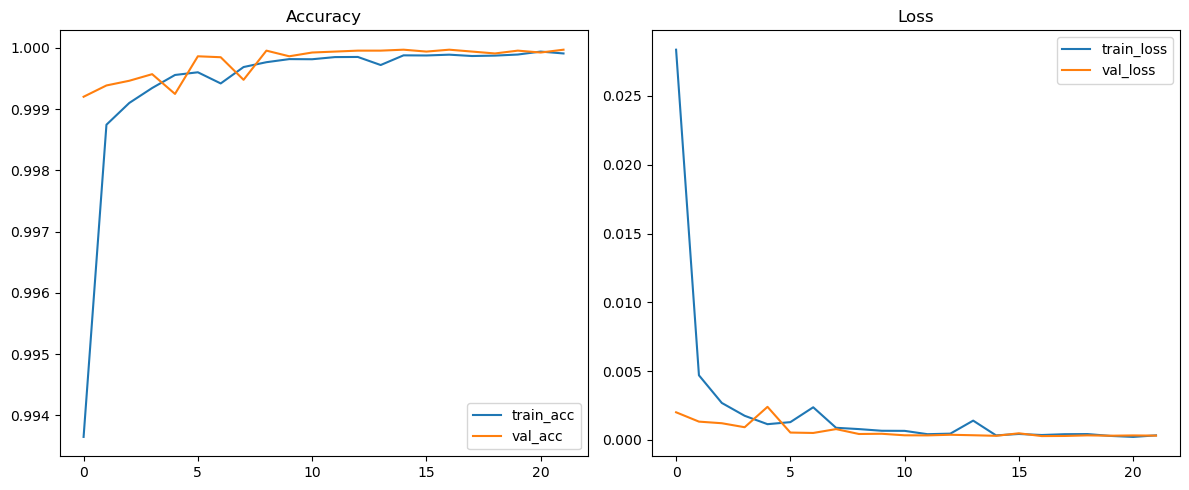

In [3]:
# ----------------------------
# 5. Train/Test Split
# ----------------------------
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]
print("Train/test shapes:", X_train.shape, X_test.shape)

# one-hot encode for training
num_classes  = len(encoder.classes_)
y_train_cat  = to_categorical(y_train, num_classes)
y_test_cat   = to_categorical(y_test,  num_classes)

# ----------------------------
# 6. Build & Train LSTM Model
# ----------------------------
class TimeHistory(Callback):
    def on_epoch_begin(self, epoch, logs=None): self.start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        dt = time.time()-self.start
        print(f"Epoch {epoch+1}/{self.params['epochs']} – {dt:.1f}s – "
              f"loss:{logs['loss']:.4f} val_loss:{logs['val_loss']:.4f} "
              f"val_acc:{logs['val_accuracy']:.4f}")

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, X_scaled.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

callbacks = [
    TimeHistory(),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(os.path.join(output_folder,"best_lstm.keras"),
                    monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train_cat,
    epochs=50, batch_size=128,
    validation_split=0.125,
    callbacks=callbacks,
    verbose=0
)

model.save(os.path.join(output_folder,"lstm_model.keras"))
pd.DataFrame(history.history).to_csv(
    os.path.join(output_folder,"training_history.csv"), index=False
)

# plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title("Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title("Loss")
plt.tight_layout()
plt.savefig(os.path.join(output_folder,"training_history.png"))
plt.show()

In [ ]:
import seaborn as sns


ModuleNotFoundError: No module named 'sns'

Test loss:0.0003, acc:1.0000
  37/4069 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step   

2025-04-25 18:52:58.427279: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


4069/4069 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step

                          precision    recall  f1-score   support

                  Benign     1.0000    1.0000    1.0000     72301
        DDOS attack-HOIC     1.0000    1.0000    1.0000     20736
    DDOS attack-LOIC-UDP     1.0000    1.0000    1.0000        60
  DDoS attacks-LOIC-HTTP     1.0000    0.9999    1.0000     17187
   DoS attacks-GoldenEye     1.0000    0.9993    0.9997      1509
        DoS attacks-Hulk     1.0000    0.9999    1.0000     13737
DoS attacks-SlowHTTPTest     0.9995    1.0000    0.9998      4290
   DoS attacks-Slowloris     0.9973    1.0000    0.9987       370

                accuracy                         1.0000    130190
               macro avg     0.9996    0.9999    0.9998    130190
            weighted avg     1.0000    1.0000    1.0000    130190



NameError: name 'sns' is not defined

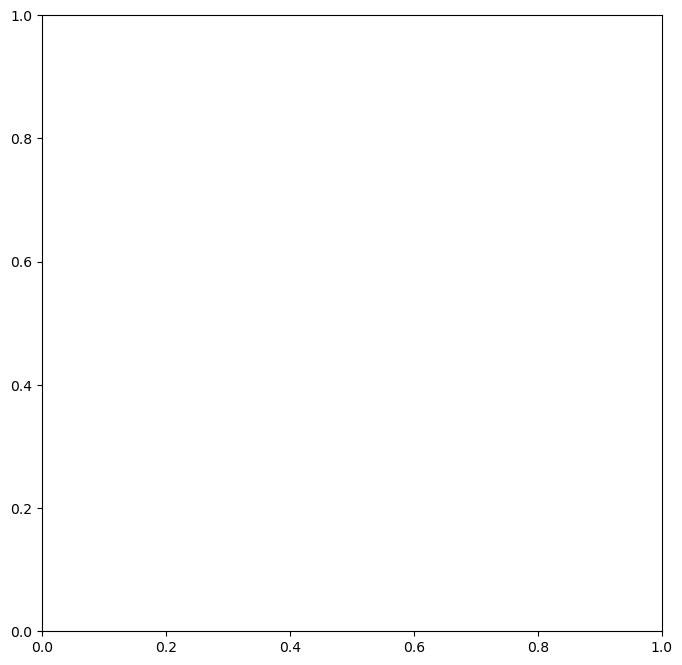

In [4]:
# ----------------------------
# 7. Evaluation
# ----------------------------
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test loss:{test_loss:.4f}, acc:{test_acc:.4f}")

# predict classes
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)

# recover string labels via the saved encoder
y_test_labels = encoder.inverse_transform(y_test)
y_pred_labels = encoder.inverse_transform(y_pred)

# classification report
class_names = list(encoder.classes_)
report = classification_report(y_test_labels, y_pred_labels,
                               target_names=class_names, digits=4)
print("\n" + report)

# confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size":12}, linewidths=0.5)
ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(output_folder,"confusion_matrix.png"))
plt.show()

# AUC-ROC
y_test_bin = label_binarize(y_test, classes=list(range(num_classes)))
auc = roc_auc_score(y_test_bin, y_prob, average="weighted", multi_class="ovr")
print(f"AUC-ROC: {auc:.4f}")

# save metrics
with open(os.path.join(output_folder,"test_evaluation_metrics.txt"),"w") as f:
    f.write(f"Test loss: {test_loss:.4f}\nTest acc: {test_acc:.4f}\n\n")
    f.write("Classification Report:\n"+report+"\n")
    f.write("Confusion Matrix:\n"+str(cm)+"\n\n")
    f.write(f"AUC-ROC: {auc:.4f}\n")

print("Done. All outputs in", output_folder)